# Fundamentals of Machine Learning - Exercise 4
Dominique Cheray & Jacqueline Wagner

In [6]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Data Generation with Naive Bayes

(120000, 9, 9)
(120000,)
(120000, 81)


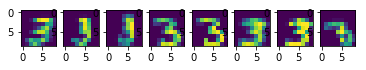

In [7]:
f = h5py.File("digits.h5")
images = f["images"].value
labels = f["labels"].value
f.close()
print(images.shape)
print(labels.shape)
# reshape the images to a feature array
features = np.reshape(images, (120000, 81))
print(features.shape)

# pick all threes and visualize eight of them
threesimg = images[labels == 3]
threesfeat = features[labels == 3]
threeslabel = labels[labels == 3]
fig = plt.figure()
for i in range(1,9):
    fig.add_subplot(1, 8, i)
    plt.imshow(threesimg[i])
plt.show()

In [9]:
# naive bayes from last exercise
def fit_naive_bayes(features, labels, bincount=0):
    unique_labels = np.unique(labels)
    N = len(features)
    L = bincount
    histograms = []
    binning = []
    # if no bincount is given determine it according to freedman diaconis
    if bincount == 0:
        iqrs = stats.iqr(features, axis=0)
        delta_x = iqrs[:] * 2.0 / (N ** (1.0/3.0))
        delta_x[delta_x == 0] = np.max(features)
        nr_bins = np.ceil((np.max(features, axis=0) - np.min(features, axis=0)) / delta_x)
        L = int(np.mean(nr_bins))
    for label in unique_labels:
        cl = features[labels == label]
        # adapt delta_x to bincount (either given or determined by freedman diaconis)
        delta_x = ((np.max(cl, axis=0) - np.min(cl, axis=0)) / (L-1))
        delta_x[delta_x == 0] = np.max(cl)
        lower_bound = np.min(cl, axis=0)
        binshape = np.zeros((len(features[0]), 2))
        binshape[:, 0] = lower_bound
        binshape[:, 1] = delta_x
        binning.append(binshape)
        # assign a bin nr to every feature of every instance of this class
        bins = np.floor((cl - lower_bound)/delta_x).astype(int)
        hist = np.zeros((len(cl[0]), (L)))
        for i in range(len(cl[0])):
            # for every feature fill the bins of the histogram
            # with the probability for x in bin
            values, counts = np.unique(bins[:, i], return_counts=True)
            hist[i][values] = counts / (len(cl))
        histograms.append(hist)
    histograms = np.asarray(histograms)
    binning = np.asarray(binning)
    return histograms, binning

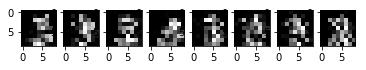

In [33]:
def sample_naive_bayes(histograms, binning):
    ql = np.cumsum(histograms[0], axis=1)
    # generate random ts for every pixel
    t = np.random.rand(len(histograms[0]))
    # for every pixel select a bin
    smallest_l = np.argmax(ql >= np.expand_dims(t, axis=1), axis=1)
    # determine bounds for unifor distribution
    # lower bound = lower bound of first bin + (binwidth * (binnumber+ 1))
    # binnumber +1 because bins start at zero
    lower_boud = binning[0, :, 0] + binning[0, :, 1] * (smallest_l + 1)
    # upper bound = lower bound + binwidth
    upper_bound = lower_boud + binning[0, :, 1]
    # sample pixels from uniform distribution
    img = np.random.uniform(lower_boud, upper_bound)
    # reshape flat image to a 9x9 image and return it
    return img.reshape(9, 9)


# fit the bayes on the threes
hist, binning = fit_naive_bayes(threesfeat, threeslabel)
# now generate eight new threes and show them
fig = plt.figure()
for i in range(1, 9):
    img = sample_naive_bayes(hist, binning)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()
# with lots of imagination you might see that these are new threes

## Data Generation with a Multi-dimensional Gaussian

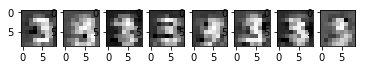

In [34]:
def fit_gaussian(features):
    mu = np.mean(features, axis=0)
    covmat = np.cov(features, rowvar=False)
    return mu, covmat

# fit the gaussian on the threes
mu, covmat = fit_gaussian(threesfeat)
# now generate eight new threes and show them
fig = plt.figure()
for i in range(1, 9):
    img = np.random.multivariate_normal(mu, covmat).reshape(9, 9)
    fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap="Greys_r")
plt.show()